<a href="https://colab.research.google.com/github/ridash2005/pytorch-learn/blob/main/Module_6(PART%202).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Fine-tuning Pretrained Models for Image Classification

In the previous notebook, we learned how Transfer Learning to train a Convolutional Neural Network (CNN).

## Quick Refresher

A typical image classification architecture consists of 4 parts


1.   Input image
2.   Feature Extractor - a bank of convolutional layers that extract useful features for classification.
3.   Classifier - a bank of fully connected layers that classify the image into its output classes.  
4.   Output vector of class probabilities


<img src=https://learnopencv.com/wp-content/uploads/2024/07/Transfer-learning.png align='center'><br/>

Before we proceed with the coding implementation of Fine Tuning it's helpful to review the table below, which summarizes several use cases.

<img src=https://learnopencv.com/wp-content/uploads/2023/03/tensorflow-keras-training-methods.png width=850 align='center'><br/>


In a previous notebook, we showed how you can use pre-trained ImageNet models to perform classification.



In this notebook, we will fine-tune a **Mobilenet v3 small** model with ImageNet pretrained weights on the same [10 Monkey Species](https://www.kaggle.com/slothkong/10-monkey-species) dataset.

We will understand the significance of fine-tuning a pretrained model to adapt to a dataset that has shared features with ImageNet.

<center><img src='https://learnopencv.com/wp-content/uploads/2024/08/torchvision-pretrained-classification.png'></center>



## Table of Content

* [1. Download and Extract the Dataset](#1.-Download-and-Extract-the-Dataset)
* [2. Dataset and Training Configuration Parameters](#2.-Dataset-and-Training-Configuration-Parameters)
* [3. Dataset Preprocessing](#3.-Dataset-Preprocessing)
* [4. Fine-tuning with Pretrained Model](#4-Fine-tuning-with-Pretrained-Model)
* [5. Model Training and Evaluation](#5.-Model-Training-and-Evaluation)
* [6. Saving and Loading Best Model Weights](#6.-Saving-and-Loading-Best-Model-Weights)
* [7. Inference](#7.-Inference)
* [8. Conclusion](#8.-Conclusion)

## Import Dependencies

In [ ]:
!pip install -q torchinfo

In [ ]:
import torch  # PyTorch core library for deep learning
import torch.nn as nn  # Neural network module in PyTorch
from torch.optim import Adam  # Adam optimizer for training models
import torch.nn.functional as F  # Functional interface for PyTorch layers
from torch.utils.data import DataLoader, Dataset  # Utilities for handling datasets and data loading
from torchinfo import summary  # Prints model architecture summary
from torch.utils.tensorboard import SummaryWriter  # Logging utility for TensorBoard

import torchvision  # PyTorch's library for image processing
from torchvision import datasets  # Datasets module for common image datasets
from torchvision.transforms import v2 as transforms  # Image transformation utilities
from torchvision.ops import Conv2dNormActivation  # Convolution layers with normalization and activation

from dataclasses import dataclass  # Data structure utility for structured storage
from sklearn.metrics import confusion_matrix  # Computes confusion matrix for classification
from sklearn.model_selection import train_test_split  # Splits dataset into training and testing sets
import seaborn as sn  # Data visualization library, often used for heatmaps

import matplotlib.pyplot as plt  # Visualization library for creating plots
import time  # Provides time-related functions
import numpy as np  # Library for numerical computing and array operations
import random  # Standard library module for generating random numbers
import warnings  # Handles warning messages
import os  # Provides functionalities for interacting with the operating system
from tqdm import tqdm  # Displays progress bars for loops

import pandas as pd  # Library for data manipulation and analysis
import random  # Included twice, can be removed if unnecessary
# Ensures inline plotting in Jupyter notebooks
%matplotlib inline
warnings.filterwarnings("ignore")  # Suppresses warning messages


In [ ]:
#Set seed for reproducibilty
def set_seed(seed):
    random.seed(seed)  # Set the seed for Python's built-in random module
    np.random.seed(seed)  # Set the seed for NumPy's random number generator
    torch.manual_seed(seed)  # Set the seed for PyTorch's random number generator

    if torch.cuda.is_available():  # Check if a CUDA-enabled GPU is available
       torch.cuda.manual_seed(seed)  # Set the seed for CUDA (single GPU)
       torch.cuda.manual_seed_all(seed)  # Set the seed for CUDA (multiple GPUs)
       torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior for CuDNN
       torch.backends.cudnn.benchmark = True  # Enable benchmark mode for CuDNN (can improve performance)

set_seed(42)  # Set the random seed to 42 for reproducibility

## 1. Download and Extract the Dataset

<center><img src='https://www.dropbox.com/scl/fi/m5kngoab3d9p6ajbffwr9/Monkey-Species-Dataset.jpg?rlkey=t62unc200y259ltk5kqlxa9cj&st=334vllym&dl=1' width=500 height=500></center>



In [ ]:
!wget -q "https://www.dropbox.com/s/45jdd8padeyjq6t/10_Monkey_Species.zip?dl=1" -O "10_Monkey_Species.zip"

In [ ]:
!unzip -q "10_Monkey_Species.zip"

## 2. Dataset and Training Configuration Parameters

Before we describe the model implementation and training, we’re going to apply a little more structure to our training process by using the `dataclasses` module in python to create simple `DatasetConfig` and `TrainingConfig` classes to organize several data and training configuration parameters. This allows us to create data structures for configuration parameters, as shown below. The benefit of doing this is that we have a single place to go to make any desired changes.

In [ ]:
@dataclass(frozen=True)  # Creating an immutable dataclass for training configuration
class TrainingConfig:
      ''' Configuration for Training '''
      batch_size: int = 32  # Number of samples per training batch
      num_epochs: int = 20  # Number of epochs (full passes through dataset)
      learning_rate: float = 1e-4  # Learning rate for optimizer

      log_interval: int = 1  # Interval at which to log training progress
      test_interval: int = 1  # Interval at which to test model performance
      data_root: int = "./"  # Path to dataset storage
      num_workers: int = 5  # Number of worker processes for data loading
      device: str = "cuda"  # Default device for training (CUDA if available)

# Creating an instance of the training configuration
train_config = TrainingConfig()

# Determining whether to use a GPU (if available) or CPU
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print("Available Device: ", DEVICE)  # Print the selected device


Available Device:  cuda


<h3 style="font-size:30px;">2.1. Load Custom Datasets in PyTorch</h3>

Till now, we have experimented with datasets like Fashion MNIST available with the PyTorch Torchvision library.

In this notebook, we will see how to load raw images present in a folder.

In the real world, we have need the manage the structure and preprocessing of the dataset on our own.

To illustrate a few preprocessing, we have chosen the [10 Monkey Species](https://www.kaggle.com/slothkong/10-monkey-species) dataset from Kaggle. You can download the data from [here](https://www.kaggle.com/slothkong/10-monkey-species/download). You need to extract data. We have already uploaded the extracted data in the lab.

Each folder contains 10 subforders labeled as n0~n9, each corresponding a species form Wikipedia's monkey cladogram. Images are 400x300 px or larger and JPEG format (almost 1400 images). Images were downloaded with help of the googliser open source code.

**Label mapping:**

| Label | Monkey Species |
| --- | --- |
| n0 | alouatta_palliata |
| n1 | erythrocebus_patas |
| n2 | cacajao_calvus |
| n3 | macaca_fuscata |  
| n4 | cebuella_pygmea |
| n5 | cebus_capucinus |
| n6 | mico_argentatus |
| n7 | saimiri_sciureus |
| n8 | aotus_nigriceps |
| n9 | trachypithecus_johnii |


**Extracted Folder structure:**

```
data_root
├── training
│   └── training
│       ├── n0
│       ├── n1
│       ├── n2
│       ├── n3
│       ├── n4
│       ├── n5
│       ├── n6
│       ├── n7
│       ├── n8
│       └── n9
└── validation
    └── validation
        ├── n0
        ├── n1
        ├── n2
        ├── n3
        ├── n4
        ├── n5
        ├── n6
        ├── n7
        ├── n8
        └── n9

```

`data_root/training/training` has `n0-n9` folders; each folder has images of the corresponding class. Similarly, `data_root/validation/validation` has `n0-n9` folders.

In [ ]:
# Defining the path to the training dataset
train_root = os.path.join("10_Monkey_Species", "training", "training")  # Path to training data directory

# Defining the path to the validation dataset
val_root = os.path.join(train_config.data_root, "10_Monkey_Species", "validation", "validation")  # Path to validation data directory

In [ ]:
# Reading the monkey species labels from a CSV file
# The file is stored inside the '10_Monkey_Species' directory
# The separator is a comma, and it has no header row initially

df = pd.read_csv(os.path.join("10_Monkey_Species", "monkey_labels.txt"), sep=",", header=None)

# Assigning meaningful column names to the DataFrame
df.columns = ["Label", "Latin Name", "Common Name", "Train Images", "Validation Images"]

# Cleaning up the 'Latin Name' column by replacing tab characters with spaces
df['Latin Name'] = df['Latin Name'].str.replace("\t", " ")

# Displaying all rows except the first one
df[1:]

,Label,Latin Name,Common Name,Train Images,Validation Images
1,n0,alouatta_palliata,mantled_howler,131,26
2,n1,erythrocebus_patas,patas_monkey,139,28
3,n2,cacajao_calvus,bald_uakari,137,27
4,n3,macaca_fuscata,japanese_macaque,152,30
5,n4,cebuella_pygmea,pygmy_marmoset,131,26
6,n5,cebus_capucinus,white_headed_capuchin,141,28
7,n6,mico_argentatus,silvery_marmoset,132,26
8,n7,saimiri_sciureus,common_squirrel_monkey,142,28
9,n8,aotus_nigriceps,black_headed_night_monkey,133,27
10,n9,trachypithecus_johnii,nilgiri_langur,132,26


## 3. Dataset Preprocessing

Here, we normalize the image data to the range `[0,1]` with `mean` and `std` of our Dataset. This is very common when working with image data which helps the model train more efficiently.

In [ ]:
# Mean and standard deviation values computed from the Monkey Species dataset
mean = [0.4368, 0.4336, 0.3294]  # Mean pixel values for normalization (RGB channels)
std = [0.2457, 0.2413, 0.2447]  # Standard deviation pixel values for normalization (RGB channels)

# Defining the target image size for model input
img_size = (224, 224)  # Resizing images to 224x224 pixels

# Creating a preprocessing pipeline for images
preprocess = transforms.Compose(
    [
        transforms.Resize(img_size, antialias=True),  # Resize images while preserving aspect ratio
        transforms.ToTensor()  # Convert images to PyTorch tensors (scales pixel values to [0,1])
    ]
)

In [ ]:
# Define common transformations used for both training and validation datasets
common_transforms = transforms.Compose(
    [
        preprocess,  # Apply the standard preprocessing pipeline (resize, convert to tensor)
        transforms.Normalize(mean=mean, std=std)  # Normalize images using dataset-specific mean and std
    ]
)

# Define additional transformations for training data augmentation
train_transforms = transforms.Compose(
    [
        preprocess,  # Apply the same preprocessing steps as common_transforms
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally with a probability of 0.5
        transforms.RandomErasing(p=0.4),  # Randomly erase parts of the image with a probability of 0.4

        # Apply random affine transformations with controlled randomness
        transforms.RandomApply([
            transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
        ], p=0.1),  # Apply affine transformations with a probability of 0.1

        transforms.Normalize(mean=mean, std=std)  # Normalize images using dataset-specific mean and std
    ]
)



### 3.1. DataLoader Preparation



**PyTorch has inbuilt functionality (`torchvision.datasets.ImageFolder` class) to load such structured image folders:**

```
torchvision.datasets.ImageFolder(root, transform=None, target_transform=None, loader=<function default_loader>, is_valid_file=None)
```

This is a generic data loader where the images are arranged in this way:

```
root/n0/xxx.png
root/n0/xxy.jpg
root/n0/xxz.png

root/n1/123.jpg
root/n1/nsdf3.png
root/n1/asd932_.png

    :
    :
    
root/n9/1b23.jpg
root/n9/nsasdf3.png
root/n9/as2wdd932_.png
    
```

Parameters:

- `root` (string) - Root directory path.

- `transform` (callable, optional) - A function/transform that takes in an PIL image and returns a transformed version. E.g, `transforms.RandomCrop`.

- `target_transform` (callable, optional) - A function/transform that takes in the target and transforms it.

- `loader` (callable, optional) - A function to load an image given its path.

- `is_valid_file` - A function that takes path of an Image file and check if the file is a valid file (used to check of corrupt files).

Find more details [here](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder).


In [ ]:
#Apply augmentations to the training dataset
train_data = datasets.ImageFolder(root = train_root, transform = train_transforms)

# The validation dataset should have only common transforms like Resize, ToTensor and Normalize.
val_data = datasets.ImageFolder(root=val_root, transform = common_transforms)
train_data.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [ ]:
train_data.class_to_idx

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [ ]:
len(train_data)

1097

In [ ]:
# Creating a DataLoader for training data
train_loader = DataLoader(
    train_data,  # Dataset to load
    shuffle=True,  # Shuffle data at every epoch to improve generalization
    batch_size=train_config.batch_size,  # Number of samples per batch
    num_workers=train_config.num_workers  # Number of subprocesses for data loading
)

# Creating a DataLoader for validation data
val_loader = DataLoader(
    val_data,  # Dataset to load
    shuffle=False,  # No shuffling needed for validation data
    batch_size=train_config.batch_size,  # Number of samples per batch
    num_workers=train_config.num_workers  # Number of subprocesses for data loading
)

In [ ]:
#Map class names to class ids.
class_mapping = {

    0: "mantled_howler",
    1: "patas_monkey",
    2: "bald_uakari",
    3: "japanese_macaque",
    4: "pygmy_marmoset",
    5: "white_headed_capuchin",
    6: "silvery_marmoset",
    7: "common_squirrel_monkey",
    8: "black_headed_night_monkey",
    9: "nilgiri_langur"
}

### 3.2. Display Sample Images from the Dataset


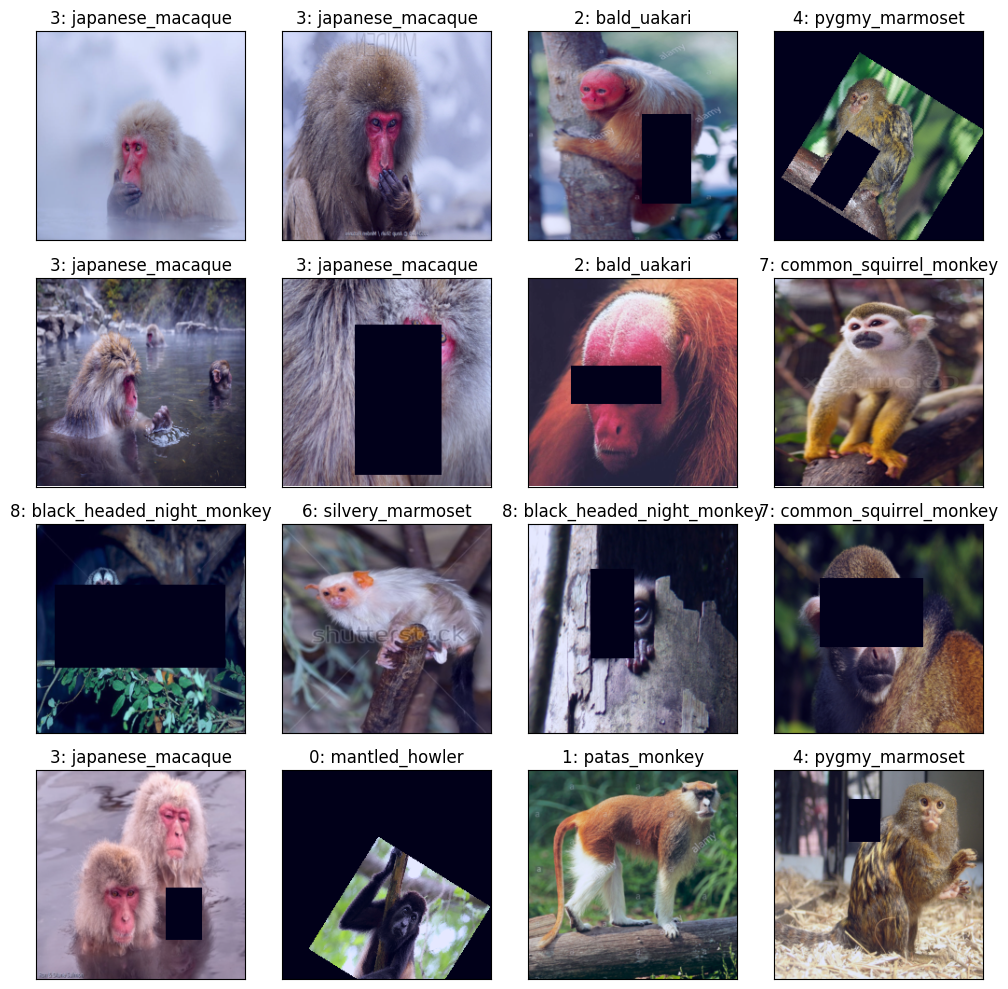

In [ ]:
import matplotlib.pyplot as plt  # Importing Matplotlib for visualization
import numpy as np  # Importing NumPy for numerical operations

def visualize_images(dataloader, num_images=20):
    """
    Function to visualize a batch of images from the DataLoader.

    Parameters:
    dataloader (DataLoader): The PyTorch DataLoader containing image data.
    num_images (int): Number of images to visualize.
    """
    fig = plt.figure(figsize=(10, 10))  # Create a figure with a specified size

    # Retrieve the first batch from the DataLoader
    images, labels = next(iter(dataloader))

    num_rows = 4  # Define number of rows in the grid
    num_cols = int(np.ceil((num_images / num_rows)))  # Compute number of columns

    for idx in range(min(num_images, len(images))):  # Loop through the images up to num_images
        image, label = images[idx], labels[idx]  # Extract image and label

        ax = fig.add_subplot(num_rows, num_cols, idx + 1, xticks=[], yticks=[])  # Create subplot

        image = image.permute(1, 2, 0)  # Reorder dimensions for visualization (C, H, W) → (H, W, C)

        # Normalize the image to [0,1] for display
        image = (image - image.min()) / (image.max() - image.min())
        ax.imshow(image, cmap="gray")  # Display the image
        ax.set_title(f"{label.item()}: {class_mapping[label.item()]}")  # Set title with label info

    fig.tight_layout()  # Adjust layout for better spacing
    plt.show()  # Display the figure

# Call the function to visualize a sample of images from the training dataset
visualize_images(train_loader, num_images=16)

## 4. Fine-tuning with Pretrained Model

We will use **mobilenet_v3_small** from torchvision classification models. MobileNetV3 Small known for its lightweight architecture and efficient performance is crucial for mobile and edge applications. It offers significant improvements in speed and accuracy, making it ideal for real-time computer vision tasks on resource-constrained devices.

[Torchvision Pretrained Classification Models](https://pytorch.org/vision/main/models.html#classification)

In [ ]:
from torchvision.models import mobilenet_v3_small

# Load the model
mobilenetv3_model = mobilenet_v3_small(weights="DEFAULT")

# Number of feature layers
num_feature_layers = len(mobilenetv3_model.features)
print(f"Number of feature layers: {num_feature_layers}")

# Number of classifier layers
num_classifier_layers = len(mobilenetv3_model.classifier)
print(f"Number of classifier layers: {num_classifier_layers}")

Number of feature layers: 13
Number of classifier layers: 4


In [ ]:
#Set requires_grad to True for all model parameters to allow training
# Freeze the earlier layers to retain pretrained low-level features
for param in mobilenetv3_model.features[:10].parameters():  # Adjust as needed
    param.requires_grad = False

In [ ]:
# Check the final classifier
print(mobilenetv3_model.classifier[3])

Linear(in_features=1024, out_features=1000, bias=True)


In [ ]:
# Replace the final linear layer of the classifier to match the number of classes in the dataset
mobilenetv3_model.classifier[3] = nn.Linear(in_features = 1024, out_features = 10, bias = True)

# Check the final classifier after modifications
print(mobilenetv3_model.classifier[3])

model = mobilenetv3_model

Linear(in_features=1024, out_features=10, bias=True)


In [ ]:
# Initializing the optimizer with model parameters and learning rate from the training configuration
optimizer = Adam(model.parameters(), lr=train_config.learning_rate)

# Selecting the appropriate device (GPU if available, otherwise CPU)
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"

# Define the directory where TensorBoard logs will be stored
logdir = "runs/mobilenetv3-Monkey-Species"

# Initialize the TensorBoard SummaryWriter for logging training details
writer = SummaryWriter(logdir)

# Print a summary of the MobileNetV3 model, specifying input shape and display settings
summary(model, input_size=(1, 3, 224, 224), row_settings=["var_names"], device="cpu")

Layer (type (var_name))                                      Output Shape              Param #
MobileNetV3 (MobileNetV3)                                    [1, 10]                   --
├─Sequential (features)                                      [1, 576, 7, 7]            --
│    └─Conv2dNormActivation (0)                              [1, 16, 112, 112]         --
│    │    └─Conv2d (0)                                       [1, 16, 112, 112]         (432)
│    │    └─BatchNorm2d (1)                                  [1, 16, 112, 112]         (32)
│    │    └─Hardswish (2)                                    [1, 16, 112, 112]         --
│    └─InvertedResidual (1)                                  [1, 16, 56, 56]           --
│    │    └─Sequential (block)                               [1, 16, 56, 56]           (744)
│    └─InvertedResidual (2)                                  [1, 24, 28, 28]           --
│    │    └─Sequential (block)                               [1, 24, 28, 28]           

## 5. Model Training and Evaluation

In [ ]:
import torch.nn.functional as F  # Importing functional API for loss computation
from tqdm import tqdm  # Importing tqdm for progress bar visualization


def train(model, train_loader):
    """
    Trains the model for one epoch using the provided training data loader.

    Parameters:
    model (torch.nn.Module): The neural network model to be trained.
    train_loader (DataLoader): The DataLoader for training data.

    Returns:
    tuple: Average training loss and training accuracy.
    """
    model.train()  # Set the model to training mode
    model.to(DEVICE)  # Move the model to the appropriate device (GPU/CPU)

    running_loss = 0  # Variable to accumulate the total loss
    correct_predictions = 0  # Counter for correctly predicted samples
    total_train_samples = 0  # Counter for total training samples

    # Iterate through the training data
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to the selected device
        optimizer.zero_grad()  # Clear gradients from the previous step
        outputs = model(images)  # Forward pass to get predictions
        loss = F.cross_entropy(outputs, labels)  # Compute cross-entropy loss
        loss.backward()  # Backpropagation to compute gradients
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate loss
        _, predicted = torch.max(outputs.data, dim=1)  # Get predicted class labels
        total_train_samples += labels.shape[0]  # Update total number of samples
        correct_predictions += (predicted == labels).sum().item()  # Count correct predictions

    train_avg_loss = running_loss / len(train_loader)  # Compute average loss
    train_accuracy = 100 * correct_predictions / total_train_samples  # Compute accuracy percentage
    return train_avg_loss, train_accuracy  # Return loss and accuracy

In [ ]:
import torch.nn.functional as F  # Importing functional API for loss computation
from tqdm import tqdm  # Importing tqdm for progress bar visualization


def validation(model, val_loader):
    """
    Evaluates the model performance using the provided validation data loader.

    Parameters:
    model (torch.nn.Module): The neural network model to be evaluated.
    val_loader (DataLoader): The DataLoader for validation data.

    Returns:
    tuple: Average validation loss and validation accuracy.
    """
    model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates)
    model.to(DEVICE)  # Move the model to the appropriate device (GPU/CPU)

    running_loss = 0  # Variable to accumulate the total loss
    correct_predictions = 0  # Counter for correctly predicted samples
    total_val_samples = 0  # Counter for total validation samples

    # Iterate through the validation data
    for images, labels in tqdm(val_loader, desc="Validation"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to the selected device

        with torch.no_grad():  # Disable gradient computation for efficiency
            outputs = model(images)  # Forward pass to get predictions

        loss = F.cross_entropy(outputs, labels)  # Compute cross-entropy loss
        running_loss += loss.item()  # Accumulate loss
        _, predicted = torch.max(outputs.data, dim=1)  # Get predicted class labels
        total_val_samples += labels.shape[0]  # Update total number of samples
        correct_predictions += (predicted == labels).sum().item()  # Count correct predictions

    val_avg_loss = running_loss / len(val_loader)  # Compute average loss
    val_accuracy = 100 * correct_predictions / total_val_samples  # Compute accuracy percentage
    return val_avg_loss, val_accuracy  # Return loss and accuracy

In [ ]:
import torch  # Importing PyTorch for model saving

def main(model, train_loader, val_loader):
    """
    Trains and validates the model over multiple epochs.

    Parameters:
    model (torch.nn.Module): The neural network model to be trained and validated.
    train_loader (DataLoader): The DataLoader for training data.
    val_loader (DataLoader): The DataLoader for validation data.

    Returns:
    tuple: Lists of training and validation losses and accuracies.
    """
    train_losses, val_losses = [], []  # Lists to store loss values for training and validation
    train_accuracies, val_accuracies = [], []  # Lists to store accuracy values for training and validation

    best_val_acc = 0.0  # Initialize the best validation accuracy
    best_weights = None  # Store the best model weights

    # Training loop for the number of epochs specified in train_config
    for epoch in range(train_config.num_epochs):
        train_loss, train_accuracy = train(model, train_loader)  # Perform training for one epoch
        val_loss, val_accuracy = validation(model, val_loader)  # Perform validation for one epoch

        # Append losses and accuracies to the respective lists
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print training progress
        print(f"Epoch {epoch+1:0>2}/{train_config.num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Logging metrics to TensorBoard
        writer.add_scalar('Loss/train', train_loss)
        writer.add_scalar('Loss/val', val_loss)
        writer.add_scalar('Accuracy/train', train_accuracy)
        writer.add_scalar('Accuracy/val', val_accuracy)

        # Save the best model based on validation accuracy
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_weights = model.state_dict()
            print(f"Saving best model...💾")
            torch.save(best_weights, "best.pt")  # Save model weights to a file

    return train_losses, train_accuracies, val_losses, val_accuracies  # Return training and validation metrics

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = main(model, train_loader, val_loader)

Validation: 100%|██████████| 9/9 [00:05<00:00,  1.53it/s]


Epoch 01/20 - Train Loss: 2.0826, Train Accuracy: 31.54% - Val Loss: 1.5556, Val Accuracy: 64.34%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


Epoch 02/20 - Train Loss: 1.5082, Train Accuracy: 67.64% - Val Loss: 0.8891, Val Accuracy: 79.78%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


Epoch 03/20 - Train Loss: 1.0147, Train Accuracy: 78.58% - Val Loss: 0.5399, Val Accuracy: 88.97%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 04/20 - Train Loss: 0.6984, Train Accuracy: 84.78% - Val Loss: 0.3590, Val Accuracy: 93.75%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.56it/s]


Epoch 05/20 - Train Loss: 0.5140, Train Accuracy: 86.51% - Val Loss: 0.2764, Val Accuracy: 94.12%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.57it/s]


Epoch 06/20 - Train Loss: 0.4202, Train Accuracy: 89.24% - Val Loss: 0.2156, Val Accuracy: 95.59%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 07/20 - Train Loss: 0.3366, Train Accuracy: 91.16% - Val Loss: 0.1865, Val Accuracy: 96.32%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]


Epoch 08/20 - Train Loss: 0.3023, Train Accuracy: 91.43% - Val Loss: 0.1625, Val Accuracy: 96.69%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]


Epoch 09/20 - Train Loss: 0.2741, Train Accuracy: 93.07% - Val Loss: 0.1491, Val Accuracy: 97.43%
Saving best model...💾


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


Epoch 10/20 - Train Loss: 0.2498, Train Accuracy: 92.89% - Val Loss: 0.1311, Val Accuracy: 96.69%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 11/20 - Train Loss: 0.2086, Train Accuracy: 94.35% - Val Loss: 0.1308, Val Accuracy: 96.32%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.58it/s]


Epoch 12/20 - Train Loss: 0.1898, Train Accuracy: 94.17% - Val Loss: 0.1184, Val Accuracy: 96.32%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.47it/s]


Epoch 13/20 - Train Loss: 0.1928, Train Accuracy: 94.53% - Val Loss: 0.1067, Val Accuracy: 97.06%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 14/20 - Train Loss: 0.1990, Train Accuracy: 94.17% - Val Loss: 0.0995, Val Accuracy: 96.32%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]


Epoch 15/20 - Train Loss: 0.1843, Train Accuracy: 95.08% - Val Loss: 0.0972, Val Accuracy: 97.43%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.51it/s]


Epoch 16/20 - Train Loss: 0.1686, Train Accuracy: 94.53% - Val Loss: 0.0918, Val Accuracy: 97.43%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Epoch 17/20 - Train Loss: 0.1554, Train Accuracy: 94.71% - Val Loss: 0.0956, Val Accuracy: 96.69%


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Epoch 18/20 - Train Loss: 0.1506, Train Accuracy: 95.44% - Val Loss: 0.0882, Val Accuracy: 96.69%


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.53it/s]


Epoch 19/20 - Train Loss: 0.1526, Train Accuracy: 95.17% - Val Loss: 0.0915, Val Accuracy: 97.06%


Validation: 100%|██████████| 9/9 [00:08<00:00,  1.12it/s]

Epoch 20/20 - Train Loss: 0.1361, Train Accuracy: 95.81% - Val Loss: 0.0964, Val Accuracy: 96.69%


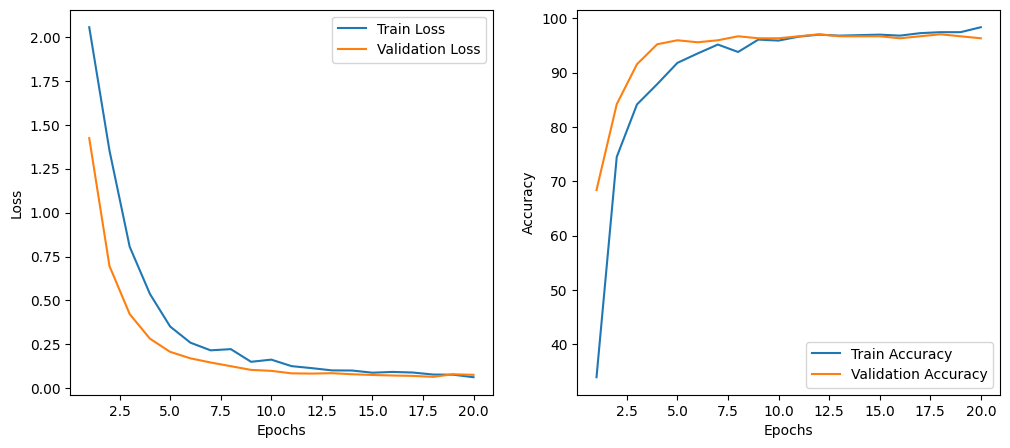

In [ ]:
import matplotlib.pyplot as plt  # Importing Matplotlib for visualization

# Create a new figure with specified size
plt.figure(figsize=(12, 5))

# Plot training and validation loss over epochs
plt.subplot(1, 2, 1)  # Create subplot (1 row, 2 columns, 1st plot)
plt.plot(range(1, train_config.num_epochs + 1), train_losses, label="Train Loss")  # Plot train loss
plt.plot(range(1, train_config.num_epochs + 1), val_losses, label="Validation Loss")  # Plot validation loss
plt.xlabel("Epochs")  # Label for x-axis
plt.ylabel("Loss")  # Label for y-axis
plt.legend()  # Show legend to differentiate lines

# Plot training and validation accuracy over epochs
plt.subplot(1, 2, 2)  # Create subplot (1 row, 2 columns, 2nd plot)
plt.plot(range(1, train_config.num_epochs + 1), train_accuracies, label="Train Accuracy")  # Plot train accuracy
plt.plot(range(1, train_config.num_epochs + 1), val_accuracies, label="Validation Accuracy")  # Plot validation accuracy
plt.xlabel("Epochs")  # Label for x-axis
plt.ylabel("Accuracy")  # Label for y-axis
plt.legend()  # Show legend to differentiate lines

plt.show()  # Display the plots


In the last notebook we have trained a **3.3 M** model for 100 epochs and achieved **86.76%** val accuracy. However here, we have fine-tuned a mobilenet v3 small model having **1.52 M** parameters and achieved a val accuracy  of **97.43%** within 15 epochs.  So, next time, why not let the pretrained models do the heavy lifting?

### 6. Saving and Loading Best Model Weights
Saving and loading best model weights are very convenient with `torch.save()`. This enables you to develop and train a model, save it to the file system and then load it with `torch.load()`.

In [ ]:
# Load the best model weights
model.load_state_dict(torch.load("best.pt"))
model.eval()

<ipython-input-38-43f5b5b4c0ea>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best.pt"))


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

## 7. Inference

In [ ]:
def prediction(model, val_loader):
    """
    Generates predictions using the trained model on validation data.

    Parameters:
    model (torch.nn.Module): The trained neural network model.
    val_loader (DataLoader): The DataLoader for validation data.

    Returns:
    tuple: Arrays containing images, true labels, predicted labels, and prediction probabilities.
    """
    model.eval()  # Set the model to evaluation mode
    model.to(DEVICE)  # Move the model to the appropriate device (GPU/CPU)

    all_images, all_labels = [], []  # Lists to store images and true labels
    all_pred_indices, all_pred_probs = [], []  # Lists to store predicted labels and probabilities

    # Iterate over the validation dataset
    for images, labels in val_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)  # Move data to selected device

        with torch.inference_mode():  # Disable gradient calculations for efficiency
            outputs = model(images)  # Forward pass to get predictions

        prob = F.softmax(outputs, dim=1)  # Convert outputs to probabilities using softmax
        pred_indices = prob.data.max(dim=1)[1]  # Get predicted class index
        pred_probs = prob.data.max(dim=1)[0]  # Get corresponding prediction confidence

        all_images.append(images.cpu())  # Move images back to CPU and store
        all_labels.append(labels.cpu())  # Move labels back to CPU and store
        all_pred_indices.append(pred_indices.cpu())  # Store predicted indices
        all_pred_probs.append(pred_probs.cpu())  # Store predicted probabilities

    return (
        torch.cat(all_images).numpy(),  # Convert list of images to NumPy array
        torch.cat(all_labels).numpy(),  # Convert list of labels to NumPy array
        torch.cat(all_pred_indices).numpy(),  # Convert list of predicted labels to NumPy array
        torch.cat(all_pred_probs).numpy()  # Convert list of prediction probabilities to NumPy array
    )


We will need to denormalize our pixel values values by multiplying std and adding mean value to our image for ***Matplotlib visualization***. `np.clip` makes the pixel values to be in range of `[0,1]`

In [ ]:
def denormalize(image):
    """
    Reverses the normalization process applied during image preprocessing.

    Parameters:
    image (numpy.ndarray or torch.Tensor): The normalized image array.

    Returns:
    numpy.ndarray: The denormalized image array with values clipped between 0 and 1.
    """
    mean_ar = np.array(mean)  # Convert mean list to NumPy array
    std_ar = np.array(std)  # Convert standard deviation list to NumPy array

    image = image * std_ar + mean_ar  # Reverse normalization transformation
    return np.clip(image, 0, 1)  # Clip values to ensure they remain within the valid range [0,1]


In [ ]:
def visualise_predictions(sample_images, sample_gt_labels, pred_indices, pred_probs, num_images=5):
    """
    Visualizes sample images along with their ground truth and predicted labels.

    Parameters:
    sample_images (numpy.ndarray): Array of sample images.
    sample_gt_labels (numpy.ndarray): Ground truth labels for the images.
    pred_indices (numpy.ndarray): Predicted class indices.
    pred_probs (numpy.ndarray): Prediction probabilities.
    num_images (int): Number of images to visualize.
    """
    fig = plt.figure(figsize=(20, 5))  # Create a figure with specified size

    for i in range(num_images):
        idx = random.randint(0, len(sample_images) - 1)  # Select a random index
        image = sample_images[idx].transpose(1, 2, 0)  # Convert (C,H,W) to (H,W,C) for display
        label = sample_gt_labels[idx]  # Get the ground truth label
        pred_idx = pred_indices[idx]  # Get the predicted class index
        pred_prob = pred_probs[idx]  # Get the corresponding prediction confidence

        image = denormalize(image)  # Denormalize the image for proper visualization

        ax = fig.add_subplot(1, num_images, i + 1)  # Create a subplot
        ax.imshow(image)  # Display the image
        ax.set_title(f"GT: {class_mapping[label]}\nPred: {class_mapping[pred_idx]} ({pred_prob:.2f})")  # Set title
        ax.axis('off')  # Remove axis labels for better display

    plt.show()  # Display the figure


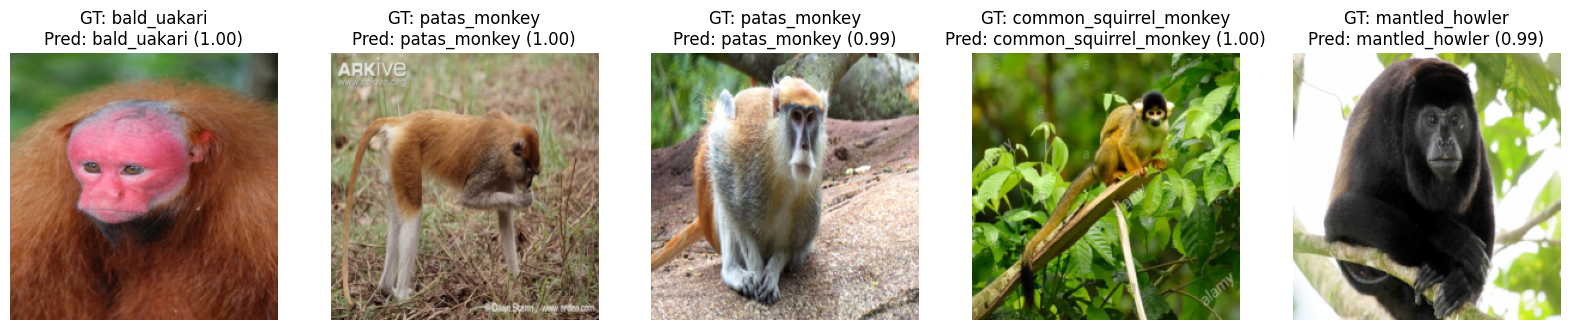

In [ ]:
# Generate predictions using the trained model on the validation dataset
val_images, val_gt_labels, pred_indices, pred_probs = prediction(model, val_loader)

# Visualize a subset of the predictions
visualise_predictions(val_images, val_gt_labels, pred_indices, pred_probs, num_images=5)

### **7.1. Confusion  matrix**



The model got it mostly right here with less false positives.

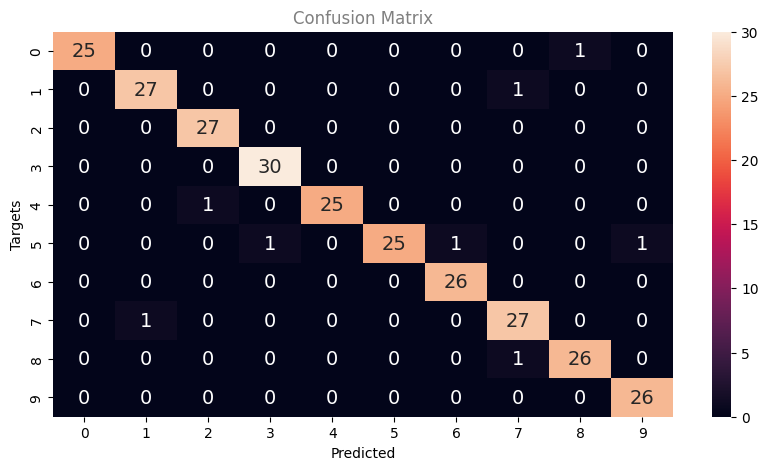

In [ ]:
# Compute the confusion matrix based on ground truth labels and model predictions
cm = confusion_matrix(y_true=val_gt_labels, y_pred=pred_indices)

# Create a figure for the confusion matrix
plt.figure(figsize=[10, 5])

# Plot the confusion matrix as a heatmap
sn.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 14})  # Display numerical values in the heatmap

# Label the axes
plt.xlabel("Predicted")  # X-axis represents predicted classes
plt.ylabel("Targets")  # Y-axis represents actual (ground truth) classes

# Set the title for the confusion matrix plot
plt.title(f"Confusion Matrix", color="gray")

# Display the plot
plt.show()

## 8. Conclusion

In this notebook, we learned how to fine-tune a torchvision classification model. **We conclude that it is often beneficial to start with fine-tuning pretrained models rather than building a model from scratch**. Fine-tuning leverages the learned features of large datasets like ImageNet, leading to faster convergence and often better performance, especially when working with smaller datasets. This approach not only saves time but also improves the overall efficiency of the training process.

By adopting a fine-tuning strategy, you can achieve high accuracy with less computational effort and fewer resources, making it a practical choice for your image classification tasks.

Additionally we encourage you to self explore on understanding about overfitting and underfitting in neural network training.